<a href="https://colab.research.google.com/github/Shaunak-Mukherjee/ME539-Scientific-Machine-Learning/blob/main/Shaunak_Mukherjee_ME539_homework_04_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4

## References

+ Lectures 13-16 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.

    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

## Student details

+ **First Name: Shaunak**
+ **Last Name: Mukherjee**
+ **Email: mukher86@purdue.edu**

# Problem 1 - Estimating the mechanical properties of a plastic material from molecular dynamics simulations

First, make sure that [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/stress_strain.txt) dataset is visible from this Jupyter notebook.
You may achieve this by either:

+ Downloading the data file and then manually upload it on Google Colab. The easiest way is to click on the folder icon on the left of the browser window and click on the upload button (or drag and drop the file). Some other options are [here](https://colab.research.google.com/notebooks/io.ipynb).
+ Downloading the file to the working directory of this notebook with this code:

In [2]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/stress_strain.txt"
download(url)

It's up to you what you choose to do.
If the file is in the right place, the following code should work:

In [3]:
data =  np.loadtxt('stress_strain.txt')

The dataset was generated using a molecular dynamics simulation of a plastic material (thanks to [Professor Alejandro Strachan](https://engineering.purdue.edu/MSE/people/ptProfile?id=33239) for sharing the data!).
Specifically, Strachan's group did the following:
- They took a rectangular chunk of the material and marked the position of each one of its atoms;
- They started applying a tensile force along one dimension.
The atoms are coupled together through electromagnetic forces, and they must all satisfy Newton's law of motion.
- For each value of the applied tensile force, they marked the stress (force be unit area) in the middle of the material and the corresponding strain of the material (percent elongation in the pulling direction).
- Eventually, the material entered the plastic regime and broke.
Here is a visualization of the data:

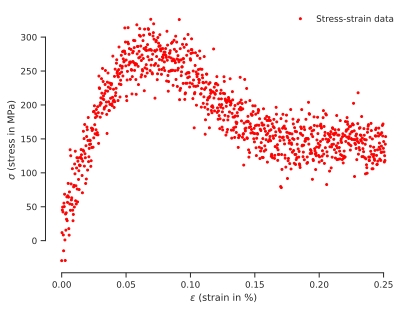

In [4]:
# Strain
x = data[:, 0]
# Stress in MPa
y = data[:, 1]

plt.figure()
plt.plot(
    x,
    y,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Note that you don't necessarily get a unique stress for each particular value of the strain.
This is because the atoms are jiggling around due to thermal effects.
So, there is always this "jiggling" noise when measuring the stress and the strain.
We want to process this noise to extract what is known as the [stress-strain curve](https://en.wikipedia.org/wiki/Stress–strain_curve) of the material.
The stress-strain curve is a macroscopic property of the material, affected by the fine structure, e.g., the chemical bonds, the crystalline structure, any defects, etc.
It is a required input to the mechanics of materials.

## Part A - Fitting the stress-strain curve in the elastic regime
The very first part of the stress-strain curve should be linear.
It is called the *elastic regime*.
In that region, say $\epsilon < \epsilon_l=0.04$, the relationship between stress and strain is:

$$
\sigma(\epsilon) = E\epsilon.
$$

The constant $E$ is known as the *Young modulus* of the material.
Assume that you measure $\epsilon$ without noise, but your measured $\sigma$ is noisy.

### Subpart A.I
First, extract the relevant data for this problem, split it into training and validation datasets, and visualize the training and validation datasets using different colors.

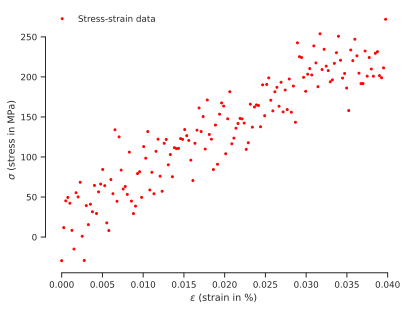

In [5]:
# The point at which the stress-strain curve stops being linear
epsilon_l = 0.04
# Relevant data (this is nice way to get the linear part of the stresses and straints)
x_rel = x[x < 0.04]
y_rel = y[x < 0.04]

# Visualize to make sure you have the right data
plt.figure()
plt.plot(
    x_rel,
    y_rel,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Split your data into training and validation.

**Hint:** You may use [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) if you wish.

In [6]:
# Split the data into training and validation datasets
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train,  y_valid = train_test_split(x_rel, y_rel)

Use the following to visualize your split:

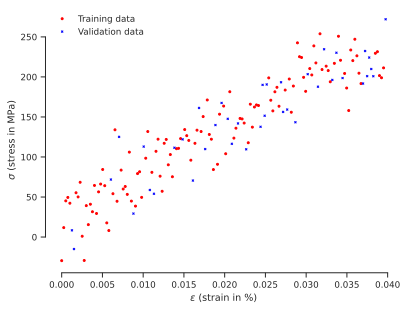

In [7]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

### Subpart A.II
Perform Bayesian linear regression with the evidence approximation to estimate the noise variance and the hyperparameters of the prior.

In [8]:
import numpy as np
from sklearn.linear_model import BayesianRidge


# Creating design matrices for polynomial model
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of `degree` evaluated at `x`.

    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    assert isinstance(x, np.ndarray), "x should be a numpy array."
    assert x.ndim == 2, "x should be a 2D array."
    assert x.shape[1] == 1, "x should have only one column."

    cols = []
    for i in range(degree + 1):
        cols.append(x ** i)
    return np.hstack(cols)

# Reshape x_train to 2D array with a single column
x_train_reshaped = x_train.reshape(-1, 1)

# Parameters since linear model
degree = 1

# Design matrix for training data
Phi_train = get_polynomial_design_matrix(x_train_reshaped, degree)

# Fit the Bayesian Ridge model
model_br = BayesianRidge(fit_intercept=False).fit(Phi_train, y_train)

# Estimated precision of the noise
sigma = np.sqrt(1.0 / model_br.alpha_)
print(f'Noise variance sigma = {sigma:.2f}')

# Weight precision alpha
alpha = model_br.lambda_
print(f'alpha = {alpha:.2e}')

print("The hyperparameters are below:")
print(f"alpha_1 = {model_br.get_params()['alpha_1']}")
print(f"alpha_2  = {model_br.get_params()['alpha_2']}")
print(f"lambda_1 = {model_br.get_params()['lambda_1']}")
print(f"lambda_2  = {model_br.get_params()['lambda_2']}")

Noise variance sigma = 26.13
alpha = 6.51e-08
The hyperparameters are below:
alpha_1 = 1e-06
alpha_2  = 1e-06
lambda_1 = 1e-06
lambda_2  = 1e-06


### Subpart A.III
Calculate the mean square error of the validation data.

In [9]:
from sklearn.metrics import mean_squared_error
# Reshape x_valid to 2D array with a single column
x_valid_reshaped = x_valid.reshape(-1, 1)

# Design matrix for validation data
Phi_valid = get_polynomial_design_matrix(x_valid_reshaped, degree)

# Predict using the model
y_predict, y_std = model_br.predict(Phi_valid, return_std=True)

# Calculate the mean squared error for validation data
mse = mean_squared_error(y_valid, y_predict)
print(f"The mean squared error of the validation data is {mse:.2f} MPa2")

The mean squared error of the validation data is 802.45 MPa2


### Subpart A.IV
Make the observations vs predictions plot for the validation data.

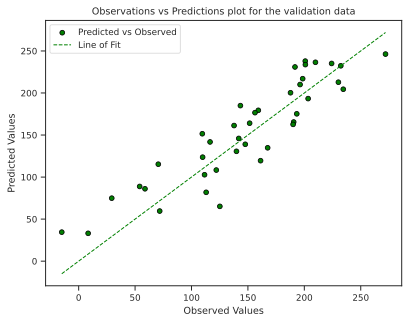

In [10]:
# Plot observed vs predicted values
plt.figure()
plt.scatter(y_valid, y_predict, c='green', marker='o', edgecolor='black', label='Predicted vs Observed')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'g--', lw=1, label='Line of Fit')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Observations vs Predictions plot for the validation data')
plt.legend(loc='best')
plt.show()

### Subpart A.V
Compute and plot the standardized errors for the validation data.

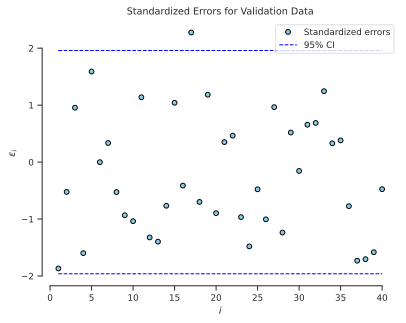

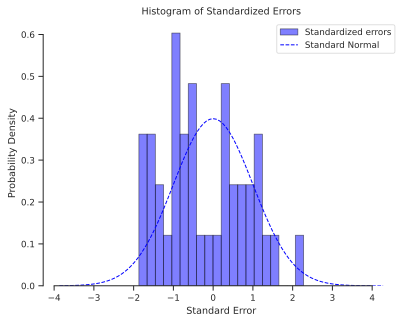

In [11]:
# Computation of standardized errors

def compute_standardized_errors(y_valid, y_predict, y_std):
    return (y_valid - y_predict) / y_std

def plot_standardized_errors(eps):

    idx = np.arange(1, eps.shape[0] + 1)

    fig, ax = plt.subplots()
    ax.plot(idx, eps, 'o', color='skyblue', markeredgewidth=1, markeredgecolor='black', label='Standardized errors')
    ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'b--', lw=1, label='95% CI')
    ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'b--', lw=1)
    ax.set_xlabel('$i$')
    ax.set_ylabel('$\epsilon_i$')
    ax.legend(loc='upper right')
    sns.despine(trim=True)
    plt.title('Standardized Errors for Validation Data')
    plt.show()

def plot_histogram_of_standardized_errors(eps):

    fig, ax = plt.subplots()
    ax.hist(eps, bins=20, alpha=0.5, density=True, color="blue", edgecolor='black', label='Standardized errors')

    err_sample_points = np.linspace(eps.min() - 2, eps.max() + 2, 100)

    ax.plot(
        err_sample_points,
        st.norm.pdf(err_sample_points), 'b--', lw=1, label="Standard Normal"
    )
    ax.set_xlabel("Standard Error")
    ax.set_ylabel("Probability Density")
    ax.legend()
    sns.despine(trim=True)
    plt.title('Histogram of Standardized Errors')
    plt.show()


# Compute standardized errors
eps = compute_standardized_errors(y_valid, y_predict, y_std)

# Plot standardized errors
plot_standardized_errors(eps)

# Plot histogram of standardized errors
plot_histogram_of_standardized_errors(eps)

### Subpart A.VI
Make the quantile-quantile plot of the standardized errors.

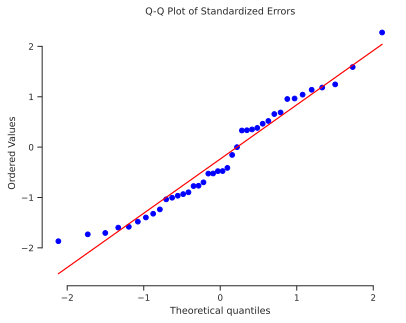

In [12]:
def plot_qq_of_standardized_errors(eps):
    """
    Plot Quantile-Quantile (Q-Q) plot of the standardized errors.

    Parameters:
    eps (array): Standardized errors.
    """
    fig, ax = plt.subplots()
    st.probplot(eps, dist=st.norm, plot=ax)
    ax.set_title('Q-Q Plot of Standardized Errors')
    sns.despine(trim=True)
    plt.show()

# Plot Q-Q plot of standardized errors
plot_qq_of_standardized_errors(eps)

### Subpart A.VII
Visualize your epistemic and the aleatory uncertainty about the stress-strain curve in the elastic regime.

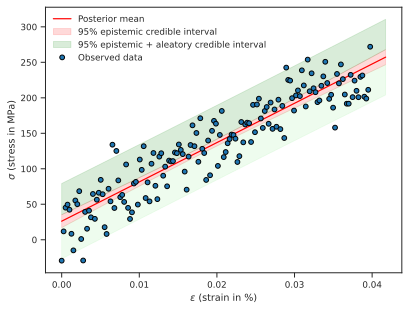

In [13]:
def plot_posterior_predictive(
    model,
    xx,
    phi_func,
    phi_func_args=(),
    y_true=None
):
    """Plot the posterior predictive separating
    aleatory and espitemic uncertainty.

    Arguments:
    model    -- A trained model.
    xx       -- The points on which to evaluate
                the posterior predictive.
    phi_func -- The function to use to compute
                the design matrix.

    Keyword Arguments:
    phi_func_args -- Any arguments passed to the
                     function that calculates the
                     design matrix.
    y_true        -- The true response for plotting.
    """
    Phi_xx = phi_func(
        xx[:, None],
        *phi_func_args
    )
    yy_mean, yy_measured_std = model.predict(
        Phi_xx,
        return_std=True
    )
    sigma = np.sqrt(1.0 / model.alpha_)
    yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
    yy_le = yy_mean - 2.0 * yy_std
    yy_ue = yy_mean + 2.0 * yy_std
    yy_lae = yy_mean - 2.0 * yy_measured_std
    yy_uae = yy_mean + 2.0 * yy_measured_std

    fig, ax = plt.subplots()
    ax.plot(xx, yy_mean, 'r', label="Posterior mean")
    ax.fill_between(
        xx,
        yy_le,
        yy_ue,
        color='red',
        alpha=0.15,
        label="95% epistemic credible interval"
    )
    ax.fill_between(
        xx,
        yy_lae,
        yy_le,
        color='lightgreen',
        alpha=0.15
    )
    ax.fill_between(
        xx,
        yy_ue,
        yy_uae,
        color='green',
        alpha=0.15,
        label="95% epistemic + aleatory credible interval"
    )
    ax.plot(x_rel, y_rel, 'o', markeredgecolor='black', label='Observed data')

    if y_true is not None:
        ax.plot(xx, y_true, "--", label="True response")
    ax.set_xlabel('$\epsilon$ (strain in %)')
    ax.set_ylabel('$\sigma$ (stress in MPa)')
    plt.legend(loc="best", frameon=False)
    # sns.despine(trim=True);

# Generate the range for xx based on x_rel
xx = np.linspace(0, x_rel.max() * 1.05, 100)

# Plot posterior predictive
plot_posterior_predictive(
    model_br,
    xx,
    get_polynomial_design_matrix,
    phi_func_args=(degree,),
    y_true=None  # Provide true response if available
)

### Subpart A. VIII
Visualize the posterior of the Young modulus E conditioned on the data.

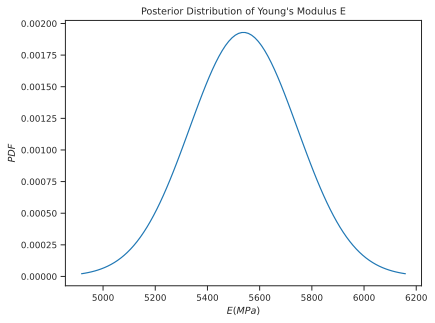

5537.96


In [14]:
E_mean_post = model_br.coef_[1]
std_post = np.sqrt(model_br.sigma_[1][1])

# Generate sample points for plotting
x_sample_points = np.linspace(E_mean_post - 3 * std_post, E_mean_post + 3 * std_post, 100)

# Plot the posterior distribution
fig, ax = plt.subplots()
ax.plot(x_sample_points, st.norm.pdf(x_sample_points, loc=E_mean_post, scale=std_post))
ax.set_xlabel("$E(MPa)$")
ax.set_ylabel("$PDF$")
ax.set_title("Posterior Distribution of Young's Modulus E")
plt.show()
print(round(E_mean_post,2))

### Subpart A.IX
Take five samples of stress-strain curve in the elastic regime and visualize them.

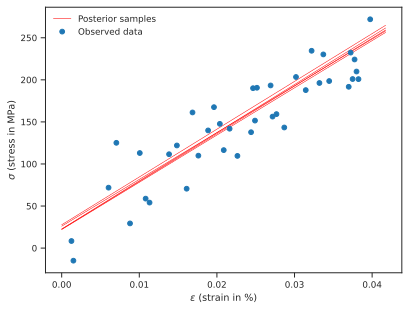

In [15]:
def plot_posterior_samples(
    model,
    xx,
    x,
    y,
    phi_func,
    phi_func_args=(),
    num_samples=10,
    y_true=None,
    yy_true=None,
    nugget=1e-6,
    xlabel="x",
    ylabel="y",
):
    """Plot posterior samples from the model.

    Arguments:
    model    -- A trained model.
    xx       -- The points on which to evaluate
                the posterior predictive.
    phi_func -- The function to use to compute
                the design matrix.

    Keyword Arguments:
    phi_func_args -- Any arguments passed to the
                     function that calculates the
                     design matrix.
    num_samples   -- The number of samples to take.
    y_true        -- The true response for plotting.
    nugget        -- A small number to add the covariance
                     if it is not positive definite
                     (numerically).
    """
    Phi_xx = phi_func(
        xx[:, None],
        *phi_func_args
    )
    m = model.coef_
    S = model.sigma_
    w_post = st.multivariate_normal(
        mean=m,
        cov=S + nugget * np.eye(S.shape[0])
    )
    fig, ax = plt.subplots()
    for _ in range(num_samples):
        w_sample = w_post.rvs()
        yy_sample = Phi_xx @ w_sample.reshape(-1, 1)
        ax.plot(xx, yy_sample, 'r', lw=0.5)
    ax.plot([], [], "r", lw=0.5, label="Posterior samples")
    ax.plot(x, y, 'o', label='Observed data')
    if y_true is not None:
        ax.plot(xx, yy_true, label='True response surface')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend(loc="best", frameon=False)


# Plot the posterior samples
plot_posterior_samples(
    model_br,
    np.linspace(0, x_valid.max() * 1.05, 100),
    x_valid,
    y_valid,
    get_polynomial_design_matrix,
    phi_func_args=(degree,),
    num_samples= 5,
    xlabel="$\epsilon$ (strain in %)",
    ylabel="$\sigma$ (stress in MPa)"
)

### Subpart A.X

Find the 95% centered credible interval for the Young modulus $E$.

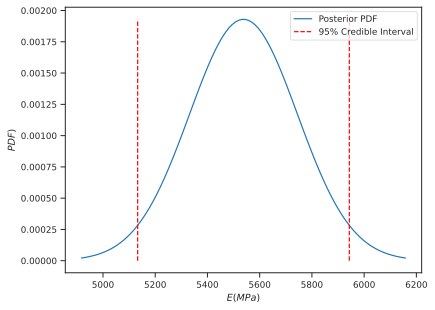

The 95% interval for E is [5132.75, 5943.18] MPa


In [16]:
# Sample points for plotting the normal distribution
x_sample_points = np.linspace(E_mean_post - 3*std_post, E_mean_post + 3*std_post, 100)

# Lower and upper bounds of the 95% credible interval
lower_95 = E_mean_post - 1.96 * std_post
upper_95 = E_mean_post + 1.96 * std_post

# PDF of the normal distribution at each sample point
pdf_values = st.norm.pdf(x_sample_points, loc=E_mean_post, scale=std_post)

# Plot the PDF
fig, ax = plt.subplots()
ax.plot(x_sample_points, pdf_values, label="Posterior PDF")

# Add vertical lines for the 95% credible interval
ax.vlines([lower_95, upper_95], 0, st.norm.pdf(E_mean_post, loc=E_mean_post, scale=std_post), colors='r', linestyles='dashed', label="95% Credible Interval")

# Labels and legend
ax.set_xlabel("$E (MPa)$")
ax.set_ylabel("$PDF)$")
ax.legend()

plt.show()

# Print the 95% interval
print(f"The 95% interval for E is [{lower_95:.2f}, {upper_95:.2f}] MPa")

### Subpart A.XI
If you had to pick a single value for the Young modulus $E$, what would it be and why?

In [17]:
# your code here
E_est = E_mean_post
print(f"My pick will be E = {E_est:.2f} Pa*10^8")

My pick will be E = 5537.96 Pa*10^8


The best estimate for single value of Young Modulus E will be the mean of the posterior data since the probability is highest at that point, as its normally distributed.

## Part B - Estimate the ultimate strength

The pick of the stress-strain curve is known as the ultimate strength.
We want to estimate it.

### Subpart B.I - Extract training and validation data

Extract training and validation data from the entire dataset.

In [18]:

# x_train, y_train, x_valid, y_valid = # Your code

x_train, x_valid, y_train, y_valid = train_test_split(x, y)

Use the following to visualize your split:

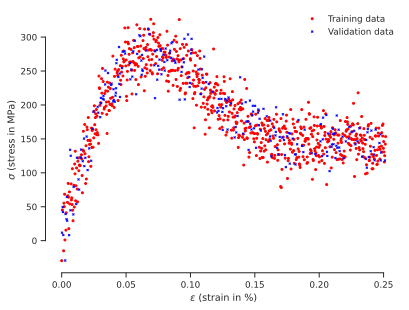

In [19]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

### Subpart B.II - Model the entire stress-strain relationship.
To do this, we will set up a generalized linear model to capture the entire stress-strain relationship.
Remember, you can use any model you want as soon as:
+ It is linear in the parameters to be estimated,
+ It has a well-defined elastic regime (see Part A).

I am going to help you set up the right model.
We will use the [Heavide step function](https://en.wikipedia.org/wiki/Heaviside_step_function) to turn on or off models for various ranges of $\epsilon$. The idea is quite simple: We will use a linear model for the elastic regime, and we are going to turn to a non-linear model for the non-linear regime.
Here is a model that has the right form in the elastic regime and an arbitrary form in the non-linear regime:

$$
f(\epsilon;E,\mathbf{w}_g) = E\epsilon \left[(1 - H(\epsilon - \epsilon_l)\right] + g(\epsilon;\mathbf{w}_g)H(\epsilon - \epsilon_l),
$$

where

$$
H(x) = \begin{cases}
0,\;\text{if}\;x < 0\\
1,\;\text{otherwise},
\end{cases}
$$

and $g$ is any function linear in the parameters $\mathbf{w}_g$.

You can use any model you like for the non-linear regime, but let's use a polynomial of degree $d$:

$$
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i.
$$

The full model can be expressed as:

$$
\begin{split}
f(\epsilon) &=
\begin{cases}
h(\epsilon) = E \epsilon,\ \epsilon < \epsilon_l, \\
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i, \epsilon \geq \epsilon_l
\end{cases}\\
&= E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
\end{split}
$$

We could proceed with this model, but there is a small problem: It is discontinuous at $\epsilon = \epsilon_l$.
This is unphysical. We can do better than that!

To make the model nice, we force the $h$ and $g$ to match up to the first derivative, i.e., we demand that:

$$
\begin{split}
h(\epsilon_l) &= g(\epsilon_l)\\
h'(\epsilon_l) &= g'(\epsilon_l).
\end{split}
$$

We include the first derivative because we don't have a kink in the stress-strain. That would also be unphysical.
The two equations above become:

$$
\begin{split}
E\epsilon_l &= \sum_{i=0}^dw_i\epsilon_l^i\\
E &= \sum_{i=1}^diw_i\epsilon_l^{i-1}.
\end{split}
$$

We can use these two equations to eliminate two weights.
Let's eliminate $w_0$ and $w_1$.
All you have to do is express them in terms of $E$ and $w_2,\dots,w_d$.
So, there remain $d$ parameters to estimate.
Let's get back to the stress-strain model.

Our stress-strain model was:

$$
f(\epsilon) = E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
$$

We can now use the expressions for $w_0$ and $w_1$ to rewrite this using only all the other
parameters.
I am going to spare you the details.
The result is:

$$
f(\epsilon) = E\epsilon + \sum_{i=2}^dw_i\left[(i-1)\epsilon_{l}^{i} - i \epsilon \epsilon_{l}^{i-1} + \epsilon^i\right]H(\epsilon - \epsilon_l).
$$

Okay.
This is still a generalized linear model. This is nice.
Write code for the design matrix:

In [20]:
def compute_design_matrix(Epsilon, epsilon_l, d):
    """Compute the design matrix for the stress-strain curve problem.

    Arguments:
        Epsilon     -     A 1D array of dimension N.
        epsilon_l   -     The strain signifying the end of the elastic regime.
        d           -     The polynomial degree.

    Returns:
        A design matrix N x d
    """
    # Sanity check
    assert isinstance(Epsilon, np.ndarray)
    # Ensure that N has only one dimension with length greater than 1
    assert np.sum(np.array(Epsilon.shape) > 1) == 1
    Epsilon = Epsilon.flatten()
    n = Epsilon.shape[0]
    # The design matrix:
    Phi = np.zeros((n, d))
    # The step function evaluated at all the elements of Epsilon.
    # You can use it if you want.
    Step = np.ones(n)
    Step[Epsilon < epsilon_l] = 0
    # Build the design matrix
    Phi[:, 0] = Epsilon
    for i in range(2, d + 1):
        Phi[:, i - 1] = (
            (i - 1) * epsilon_l**i - i * Epsilon * epsilon_l ** (i - 1) + Epsilon**i
        ) * Step
    return Phi

Visualize the basis functions here:

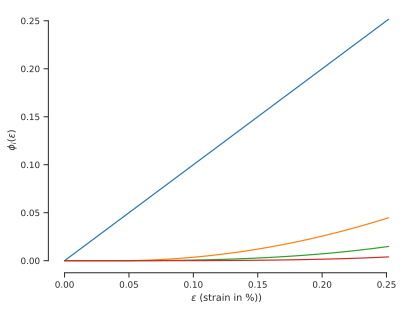

In [21]:
d = 4
eps = np.linspace(0, x.max(), 100)
Phis = compute_design_matrix(eps, epsilon_l, d)
fig, ax = plt.subplots()
ax.plot(eps, Phis)
ax.set_xlabel('$\epsilon$ (strain in %))')
ax.set_ylabel('$\phi_i(\epsilon)$')
sns.despine(trim=True);

### Subpart B.III

Fit the model using automatic relevance determination and demonstrate that it works well by doing everything we did above (MSE, observations vs. predictions plot, standardized errors, etc.).

In [22]:
from sklearn.linear_model import ARDRegression

model_ard = ARDRegression(fit_intercept=False).fit(
    compute_design_matrix(x_train, epsilon_l, d), y_train
)

y_pred, y_pred_std = model_ard.predict(
    compute_design_matrix(x_valid, epsilon_l, d), return_std=True
)

In [23]:
# Compute MSE
Phi_valid = compute_design_matrix(x_valid, epsilon_l, d)
y_pred, y_pred_std = model_ard.predict(Phi_valid, return_std=True)
print(f"The mean squared error of the validation data is {mean_squared_error(y_valid, y_pred):0.2f} MPa^2")

The mean squared error of the validation data is 749.76 MPa^2


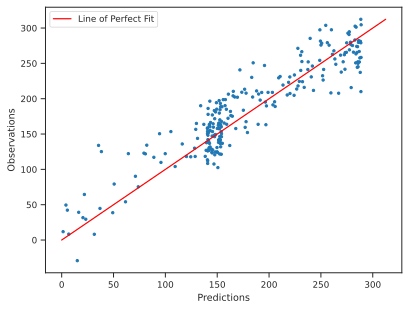

In [24]:
# Observations vs. predictions plot
fig, ax = plt.subplots()
ax.plot(y_pred, y_valid, ".")
ax.plot([0, y_valid.max()], [0, y_valid.max()], "r", label="Line of Perfect Fit")
ax.set_xlabel("Predictions")
ax.set_ylabel("Observations")
ax.legend();

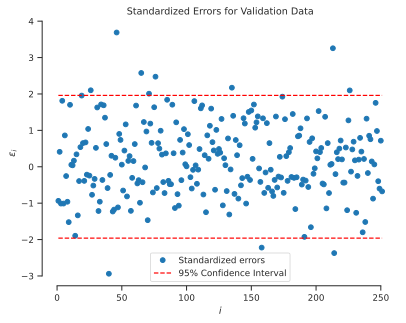

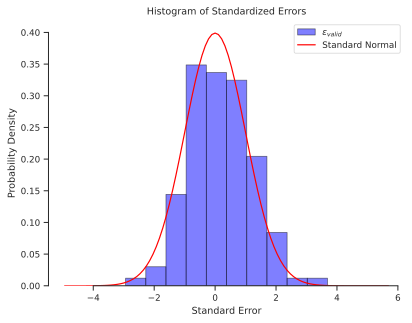

In [25]:
def compute_standardized_errors(y_valid, y_pred, y_pred_std):
    return (y_valid - y_pred) / y_pred_std

def plot_standardized_errors(eps):
    indices = np.arange(1, eps.size + 1)
    fig, ax = plt.subplots()
    ax.plot(indices, eps, 'o', label='Standardized errors')
    ax.plot(indices, 1.96 * np.ones(eps.shape[0]), 'r--')
    ax.plot(indices, -1.96 * np.ones(eps.shape[0]), 'r--', label='95% Confidence Interval')
    ax.set_xlabel('$i$')
    ax.set_ylabel('$\epsilon_i$')
    ax.legend()
    sns.despine(trim=True)
    plt.title('Standardized Errors for Validation Data')
    plt.show()

def plot_histogram_of_standardized_errors(eps):
    fig, ax = plt.subplots()
    ax.hist(eps, density=True, alpha=0.5, color='blue', edgecolor='black', label=r'$\epsilon_{valid}$')
    err_sample_points = np.linspace(eps.min() - 2, eps.max() + 2, 100)
    ax.plot(err_sample_points, st.norm.pdf(err_sample_points), 'r', label='Standard Normal')
    ax.set_xlabel('Standard Error')
    ax.set_ylabel('Probability Density')
    ax.legend()
    sns.despine(trim=True)
    plt.title('Histogram of Standardized Errors')
    plt.show()



# Compute standardized errors
standardized_errors = compute_standardized_errors(y_valid, y_pred, y_pred_std)

# Plot standardized errors
plot_standardized_errors(standardized_errors)

# Plot histogram of standardized errors
plot_histogram_of_standardized_errors(standardized_errors)


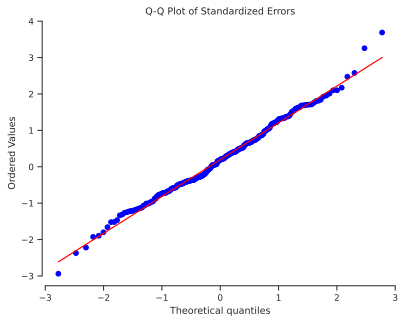

In [26]:
def plot_qq_of_standardized_errors(standardized_errors):
    """
    Plot Quantile-Quantile (Q-Q) plot of the standardized errors.

    Parameters:
    eps (array): Standardized errors.
    """
    fig, ax = plt.subplots()
    st.probplot(standardized_errors, dist=st.norm, plot=ax)
    ax.set_title('Q-Q Plot of Standardized Errors')
    sns.despine(trim=True)
    plt.show()

# Plot Q-Q plot of standardized errors
plot_qq_of_standardized_errors(standardized_errors)

### Subpart B.IV
Visualize the epistemic and aleatory uncertainty in the stess-strain relation.

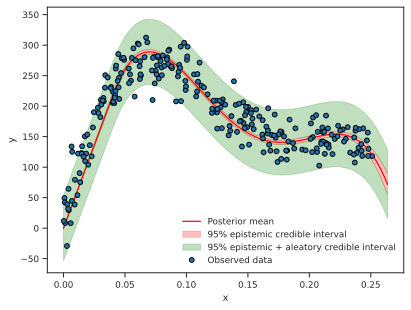

In [27]:
def plot_posterior_predictive(
    model,
    x_eval,
    x_obs,
    y_obs,
    phi_func,
    phi_func_args=(),
    y_true=None,
    xlabel="x",
    ylabel="y",
):


    """Plot the posterior predictive separating
    aleatory and espitemic uncertainty.

    Arguments:
    model    -- A trained model.
    x_eval   -- The points on which to evaluate
                the posterior predictive.
    phi_func -- The function to use to compute
                the design matrix.

    Keyword Arguments:
    phi_func_args -- Any arguments passed to the
                     function that calculates the
                     design matrix.
    y_true        -- The true response for plotting.
    """
    Phi_xx = phi_func(
        x_eval,
        *phi_func_args
    )
    yy_mean, yy_measured_std = model.predict(
        Phi_xx,
        return_std=True
    )
    sigma = np.sqrt(1.0 / model.alpha_)
    yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
    yy_le = yy_mean - 2.0 * yy_std
    yy_ue = yy_mean + 2.0 * yy_std
    yy_lae = yy_mean - 2.0 * yy_measured_std
    yy_uae = yy_mean + 2.0 * yy_measured_std

    fig, ax = plt.subplots()
    ax.plot(x_eval, yy_mean, 'r', label="Posterior mean")
    ax.fill_between(
        x_eval,
        yy_le,
        yy_ue,
        color='red',
        alpha=0.25,
        label="95% epistemic credible interval"
    )
    ax.fill_between(
        x_eval,
        yy_lae,
        yy_le,
        color='green',
        alpha=0.25
    )
    ax.fill_between(
        x_eval,
        yy_ue,
        yy_uae,
        color='green',
        alpha=0.25,
        label="95% epistemic + aleatory credible interval"
    )
    ax.plot(x_obs, y_obs, 'o', markeredgecolor='black', label='Observed data')

    if y_true is not None:
        ax.plot(x_eval, y_true, "--", label="True response")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend(loc="best", frameon=False)



# Generate the range for x_eval based on x_valid
x_eval = np.linspace(0, x_valid.max() * 1.05, 100)

# Assuming get_polynomial_design_matrix is your design matrix function
plot_posterior_predictive(
    model_ard,
    x_eval,
    x_valid,
    y_valid,
    compute_design_matrix,
    phi_func_args=(epsilon_l,d,),
    y_true= None
)

### Subpart B.V - Extract the ultimate strength

Now, you will quantify your epistemic uncertainty about the ultimate strength.
The ultimate strength is the maximum of the stress-strain relationship.
Since you have epistemic uncertainty about the stress-strain relationship, you also have epistemic uncertainty about the ultimate strength.

Do the following:
- Visualize the posterior of the ultimate strength.
- Find a 95% credible interval for the ultimate strength.
- Pick a value for the ultimate strength.

**Hint:**
To characterize your epistemic uncertainty about the ultimate strength, you would have to do the following:
- Define a dense set of strain points between 0 and 0.25.
- Repeatedly:
 + Sample from the posterior of the weights of your model
 + For each sample, evaluate the stresses at the dense set of strain points defined earlier
 + For each sampled stress vector, find the maximum. This is a sample of the ultimate strength.

The 95% Credible Interval for the Ultimate Strength is [285.07, 292.85] MPa

The selected value for the ultimate strength is the mean of the sampled values, 288.96 MPa


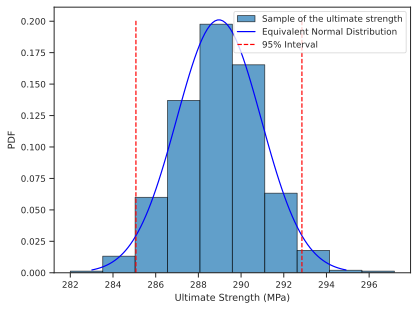

In [28]:
def quantify_epistemic_uncertainty(model_ard, epsilon_l, d, x_train, y_train):
    # Parameters for sampling
    num_samples = 1000
    strain_points = np.linspace(0, 0.25, 100)
    S_ultimate = np.zeros(num_samples)
    Phi_sample_points = compute_design_matrix(strain_points, epsilon_l, d)

    # Posterior distribution of weights
    m = model_ard.coef_
    S = model_ard.sigma_
    nugget = 1e-6
    w_post = st.multivariate_normal(mean=m, cov=S + nugget * np.eye(S.shape[0]))

    # Samples from the posterior distribution of the weights
    for i in range(num_samples):
        w_sampled = w_post.rvs()
        stress_points = Phi_sample_points @ w_sampled
        S_ultimate[i] = stress_points.max()

    # Calculate statistics
    mean_S_ultimate = S_ultimate.mean()
    std_S_ultimate = S_ultimate.std()
    norm_S_ultimate = st.norm(loc=mean_S_ultimate, scale=std_S_ultimate)
    lower_95 = norm_S_ultimate.ppf(0.025)
    upper_95 = norm_S_ultimate.ppf(0.975)
    pdf_mean = norm_S_ultimate.pdf(mean_S_ultimate)

    return S_ultimate, mean_S_ultimate, std_S_ultimate, norm_S_ultimate, lower_95, upper_95, pdf_mean

def plot_results(S_ultimate, mean_S_ultimate, std_S_ultimate, norm_S_ultimate, lower_95, upper_95, pdf_mean):
    # Plotting results
    fig, ax = plt.subplots()
    ax.hist(S_ultimate, density=True, label="Sample of the ultimate strength", edgecolor='black', alpha=0.7)
    norm_sample_x = np.linspace(mean_S_ultimate - 3 * std_S_ultimate, mean_S_ultimate + 3 * std_S_ultimate, 100)
    ax.plot(norm_sample_x, norm_S_ultimate.pdf(norm_sample_x), label="Equivalent Normal Distribution", color ='b')
    ax.vlines([lower_95, upper_95], 0, pdf_mean, "r", linestyles="--", label="95% Interval", color ='r')
    ax.set_xlabel("Ultimate Strength (MPa)")
    ax.set_ylabel("PDF")
    ax.legend()

    # Print summary
    print(f"The 95% Credible Interval for the Ultimate Strength is [{lower_95:.2f}, {upper_95:.2f}] MPa")
    print(f"\nThe selected value for the ultimate strength is the mean of the sampled values, {mean_S_ultimate:.2f} MPa")

# Apply Function
S_ultimate, mean_S_ultimate, std_S_ultimate, norm_S_ultimate, lower_95, upper_95, pdf_mean = quantify_epistemic_uncertainty(model_ard, epsilon_l, d, x_train, y_train)
plot_results(S_ultimate, mean_S_ultimate, std_S_ultimate, norm_S_ultimate, lower_95, upper_95, pdf_mean)

# Problem 2 - Optimizing the performance of a compressor

In this problem, we will need [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/compressor_data.xlsx) dataset. The dataset was kindly provided to us by [Professor Davide Ziviani](https://scholar.google.com/citations?user=gPdAtg0AAAAJ&hl=en).
As before, you can either put it on your Google Drive or just download it with the code segment below:

In [29]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/compressor_data.xlsx"
download(url)

Note that this is an Excel file, so we need pandas to read it.
Here is how:

In [30]:
import pandas as pd
data = pd.read_excel('compressor_data.xlsx')
data

,T_e,DT_sh,T_c,DT_sc,T_amb,f,m_dot,m_dot.1,Capacity,Power,Current,COP,Efficiency
0,-30,11,25,8,35,60,28.8,8.000000,1557,901,4.4,1.73,0.467
1,-30,11,30,8,35,60,23.0,6.388889,1201,881,4.0,1.36,0.425
2,-30,11,35,8,35,60,17.9,4.972222,892,858,3.7,1.04,0.382
3,-25,11,25,8,35,60,46.4,12.888889,2509,1125,5.3,2.23,0.548
4,-25,11,30,8,35,60,40.2,11.166667,2098,1122,5.1,1.87,0.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,10,11,45,8,35,60,245.2,68.111111,12057,2525,11.3,4.78,0.722
61,10,11,50,8,35,60,234.1,65.027778,10939,2740,12.3,3.99,0.719
62,10,11,55,8,35,60,222.2,61.722222,9819,2929,13.1,3.35,0.709
63,10,11,60,8,35,60,209.3,58.138889,8697,3091,13.7,2.81,0.693


The data are part of an experimental study of a variable-speed reciprocating compressor.
The experimentalists varied two temperatures, $T_e$ and $T_c$ (both in C), and they measured various other quantities.
We aim to learn the map between $T_e$ and $T_c$ and measure Capacity and Power (both in W).
First, let's see how you can extract only the relevant data.

In [31]:
# Here is how to extract the T_e and T_c columns and put them in a single numpy array
x = data[['T_e','T_c']].values
x

array([[-30,  25],
       [-30,  30],
       [-30,  35],
       [-25,  25],
       [-25,  30],
       [-25,  35],
       [-25,  40],
       [-25,  45],
       [-20,  25],
       [-20,  30],
       [-20,  35],
       [-20,  40],
       [-20,  45],
       [-20,  50],
       [-15,  25],
       [-15,  30],
       [-15,  35],
       [-15,  40],
       [-15,  45],
       [-15,  50],
       [-15,  55],
       [-10,  25],
       [-10,  30],
       [-10,  35],
       [-10,  40],
       [-10,  45],
       [-10,  50],
       [-10,  55],
       [-10,  60],
       [ -5,  25],
       [ -5,  30],
       [ -5,  35],
       [ -5,  40],
       [ -5,  45],
       [ -5,  50],
       [ -5,  55],
       [ -5,  60],
       [ -5,  65],
       [  0,  25],
       [  0,  30],
       [  0,  35],
       [  0,  40],
       [  0,  45],
       [  0,  50],
       [  0,  55],
       [  0,  60],
       [  0,  65],
       [  5,  25],
       [  5,  30],
       [  5,  35],
       [  5,  40],
       [  5,  45],
       [  5,

In [32]:
# Here is how to extract the Capacity
y = data['Capacity'].values
y

array([ 1557,  1201,   892,  2509,  2098,  1726,  1398,  1112,  3684,
        3206,  2762,  2354,  1981,  1647,  5100,  4547,  4019,  3520,
        3050,  2612,  2206,  6777,  6137,  5516,  4915,  4338,  3784,
        3256,  2755,  8734,  7996,  7271,  6559,  5863,  5184,  4524,
        3883,  3264, 10989, 10144,  9304,  8471,  7646,  6831,  6027,
        5237,  4461, 13562, 12599, 11633, 10668,  9704,  8743,  7786,
        6835,  5891, 16472, 15380, 14279, 13171, 12057, 10939,  9819,
        8697,  7575])

Fit the following multivariate polynomial model to **both the Capacity and the Power**:

$$
y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + w_7 T_e^2T_c + w_8T_eT_c^2 + w_9 T_e^3 + w_{10}T_c^3 + \epsilon,
$$

where $\epsilon$ is a Gaussian noise term with unknown variance.

**Hints:**
+ You may use [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to construct the design matrix of your polynomial features. Do not program the design matrix by hand.
+ You should split your data into training and validation and use various validation metrics to ensure your models make sense.
+ Use [ARD Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression) to fit any hyperparameters and the noise.

## Part A - Fit the capacity

### Subpart A.I

Please don't just fit. Split in training and test and use all the usual diagnostics.

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ARDRegression

# Split the data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y)

# Fit the ARDRegression model
poly = PolynomialFeatures(3)
Phi_train = poly.fit_transform(x_train)
model_ard = ARDRegression(fit_intercept=False).fit(Phi_train, y_train)

In [34]:
# Computation of MSE
Phi_valid = PolynomialFeatures(3).fit_transform(x_valid)
y_pred, y_pred_std = model_ard.predict(Phi_valid, return_std=True)
print(f"The mean squared error of the validation dataset is {mean_squared_error(y_valid, y_pred):0.2f} W^2")

The mean squared error of the validation dataset is 35.64 W^2


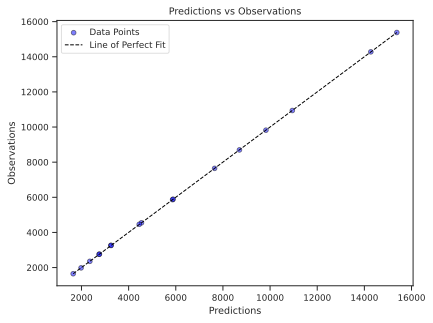

In [35]:
# Create a scatter plot with predictions vs. observations
fig, ax = plt.subplots()

# Scatter plot
ax.scatter(y_pred, y_valid, color='blue', edgecolor='k', alpha=0.5, label='Data Points')

# Line of perfect fit
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=1, label='Line of Perfect Fit')

# Plot settings
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
ax.set_title('Predictions vs Observations')
ax.legend(loc='best', frameon=True)
plt.show()

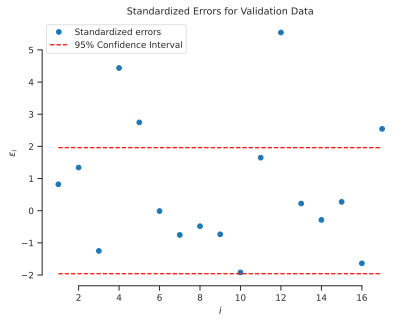

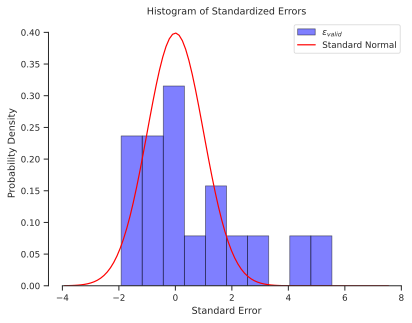

In [36]:
def compute_standardized_errors(y_valid, y_pred, y_pred_std):
    return (y_valid - y_pred) / y_pred_std

def plot_standardized_errors(eps):
    indices = np.arange(1, eps.size + 1)
    fig, ax = plt.subplots()
    ax.plot(indices, eps, 'o', label='Standardized errors')
    ax.plot(indices, 1.96 * np.ones(eps.shape[0]), 'r--')
    ax.plot(indices, -1.96 * np.ones(eps.shape[0]), 'r--', label='95% Confidence Interval')
    ax.set_xlabel('$i$')
    ax.set_ylabel('$\epsilon_i$')
    ax.legend()
    sns.despine(trim=True)
    plt.title('Standardized Errors for Validation Data')
    plt.show()

def plot_histogram_of_standardized_errors(eps):
    fig, ax = plt.subplots()
    ax.hist(eps, density=True, alpha=0.5, color='blue', edgecolor='black', label=r'$\epsilon_{valid}$')
    err_sample_points = np.linspace(eps.min() - 2, eps.max() + 2, 100)
    ax.plot(err_sample_points, st.norm.pdf(err_sample_points), 'r', label='Standard Normal')
    ax.set_xlabel('Standard Error')
    ax.set_ylabel('Probability Density')
    ax.legend()
    sns.despine(trim=True)
    plt.title('Histogram of Standardized Errors')
    plt.show()

# Compute standardized errors
standardized_errors = compute_standardized_errors(y_valid, y_pred, y_pred_std)

# Plot standardized errors
plot_standardized_errors(standardized_errors)

# Plot histogram of standardized errors
plot_histogram_of_standardized_errors(standardized_errors)

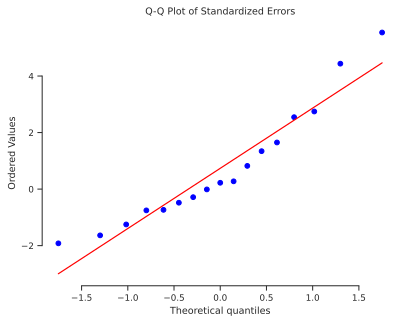

In [37]:
# QQ Plot
def plot_qq_of_standardized_errors(standardized_errors):

    fig, ax = plt.subplots()
    st.probplot(standardized_errors, dist=st.norm, plot=ax)
    ax.set_title('Q-Q Plot of Standardized Errors')
    sns.despine(trim=True)
    plt.show()

# Plot Q-Q plot of standardized errors
plot_qq_of_standardized_errors(standardized_errors)

### Subpart A.II

What is the noise variance you estimated for the Capacity?

In [38]:
# From scikit-learn: model.alpha_ is the "Estimated precision of the noise."
sigma = np.sqrt(1.0 / model_ard.alpha_)
print(f'sigma = {sigma:.2f} W^2')

sigma = 2.27 W^2


### Subpart A.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Capacity?

Weight Precisions: ['0.000', '0.000', '0.000', '0.018', '0.108', '29.927', '1559.493', '574.883', '1361.848', '15251.919']


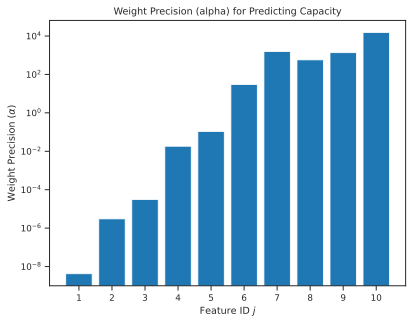

In [39]:
# Extract the weight precisions (alpha)
alpha = model_ard.lambda_
num_features = len(alpha)

formatted_alpha = [f'{a:.3f}' for a in alpha]
print(f'Weight Precisions: {formatted_alpha}')

# Plot the weight precisions (alpha) for each feature
plt.figure()
plt.bar(np.arange(num_features), alpha)
plt.xlabel('Feature ID $j$')
plt.ylabel(r'Weight Precision ($\alpha$)')
plt.yscale('log')  # Set y-axis to logarithmic scale

# Adjust x-axis ticks and labels
plt.xticks(np.arange(num_features), np.arange(num_features) + 1)
plt.title('Weight Precision (alpha) for Predicting Capacity')
plt.show()

Above plot has the weight precisions associated with the original polynomial model.We [recall](https://https://predictivesciencelab.github.io/data-analytics-se/lecture15/hands-on-15.2.html) that very high precision means that the corresponding basis function can be safely removed from your model. In this case we can remove all basis functions except first three. i.e. $$
w_1 , w_2T_e , w_3 T_c$$
Except these 3, all other alphas are several order magnitude higher.
So only important are first three indices

     Feature   Coefficient  Absolute Coefficient
0          1  15377.554685          15377.554685
1        T_e    575.242211            575.242211
2        T_c   -180.011433            180.011433
3      T_e^2      7.391330              7.391330
4    T_e T_c     -3.045107              3.045107
5      T_c^2      0.182767              0.182767
7  T_e^2 T_c     -0.041682              0.041682
8  T_e T_c^2     -0.027059              0.027059
6      T_e^3      0.025282              0.025282
9      T_c^3      0.000000              0.000000


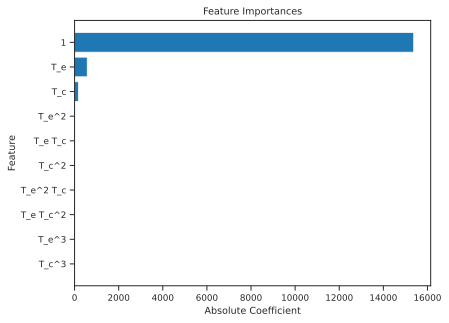

In [40]:
# Another way to look at this is to
# Extract the coefficients
coefficients_ard = model_ard.coef_

# Get the feature names
feature_names = poly.get_feature_names_out(['T_e', 'T_c'])
# coefficients with their corresponding feature names
importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients_ard})

# Sort the features by the absolute value of their coefficients
importance_df['Absolute Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)
print(importance_df)

# Plot the feature importances
plt.figure()
plt.barh(importance_df['Feature'], importance_df['Absolute Coefficient'])
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

## Part B - Fit the Power

### Subpart B.I

Please don't just fit. Split in training and test and use all the usual diagnostics.

In [41]:
y = data["Power"].values
# Split the data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y)

# Fit the ARDRegression model
poly = PolynomialFeatures(3)
Phi_train = poly.fit_transform(x_train)
model_ard = ARDRegression(fit_intercept=False).fit(Phi_train, y_train)

Phi_valid = poly.fit_transform(x_valid)
y_pred, y_pred_std = model_ard.predict(Phi_valid, return_std=True)

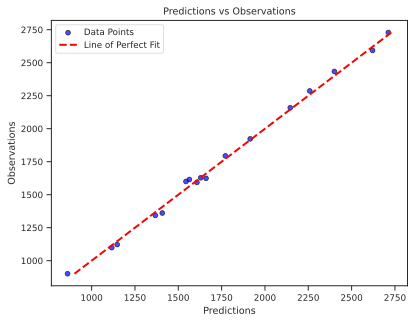

In [42]:
# Create a scatter plot with predictions vs. observations
fig, ax = plt.subplots()

# Scatter plot
ax.scatter(y_pred, y_valid, color='blue', edgecolor='k', alpha=0.7, label='Data Points')

# Line of perfect fit
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', lw=2, label='Line of Perfect Fit')

# Plot settings
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
ax.set_title('Predictions vs Observations')
ax.legend(loc='best', frameon=True)
plt.show()

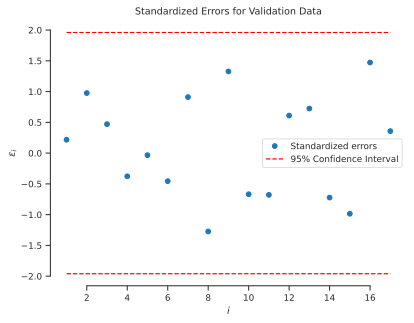

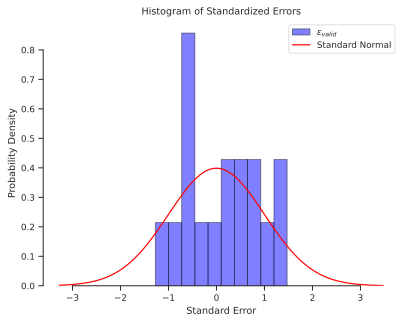

In [43]:
def compute_standardized_errors(y_valid, y_pred, y_pred_std):
    return (y_valid - y_pred) / y_pred_std

def plot_standardized_errors(eps):
    indices = np.arange(1, eps.size + 1)
    fig, ax = plt.subplots()
    ax.plot(indices, eps, 'o', label='Standardized errors')
    ax.plot(indices, 1.96 * np.ones(eps.shape[0]), 'r--')
    ax.plot(indices, -1.96 * np.ones(eps.shape[0]), 'r--', label='95% Confidence Interval')
    ax.set_xlabel('$i$')
    ax.set_ylabel('$\epsilon_i$')
    ax.legend()
    sns.despine(trim=True)
    plt.title('Standardized Errors for Validation Data')
    plt.show()

def plot_histogram_of_standardized_errors(eps):
    fig, ax = plt.subplots()
    ax.hist(eps, density=True, alpha=0.5, color='blue', edgecolor='black', label=r'$\epsilon_{valid}$')
    err_sample_points = np.linspace(eps.min() - 2, eps.max() + 2, 100)
    ax.plot(err_sample_points, st.norm.pdf(err_sample_points), 'r', label='Standard Normal')
    ax.set_xlabel('Standard Error')
    ax.set_ylabel('Probability Density')
    ax.legend()
    sns.despine(trim=True)
    plt.title('Histogram of Standardized Errors')
    plt.show()

# Compute standardized errors
standardized_errors = compute_standardized_errors(y_valid, y_pred, y_pred_std)

# Plot standardized errors
plot_standardized_errors(standardized_errors)

# Plot histogram of standardized errors
plot_histogram_of_standardized_errors(standardized_errors)

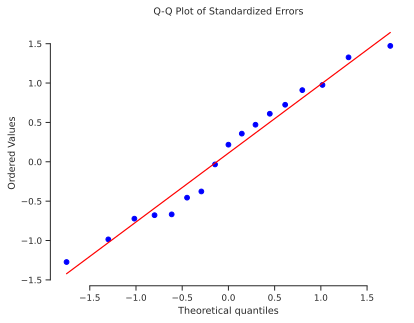

In [44]:
# QQ Plot
def plot_qq_of_standardized_errors(standardized_errors):

    fig, ax = plt.subplots()
    st.probplot(standardized_errors, dist=st.norm, plot=ax)
    ax.set_title('Q-Q Plot of Standardized Errors')
    sns.despine(trim=True)
    plt.show()

# Plot Q-Q plot of standardized errors
plot_qq_of_standardized_errors(standardized_errors)

### Subpart B.II

What is the noise variance you estimated for the Power?

In [45]:
# your code here
noise_variance = np.sqrt(1 / model_ard.alpha_)
print(f"The Power's noise variance is {noise_variance:.2f} W^2")

The Power's noise variance is 35.43 W^2


### Subpart B.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Power?

Weight Precisions: ['0.000', '0.006', '0.000', '1.365', '83803.629', '6.633', '196511.295', '10715.688', '2395.756', '42993.483']


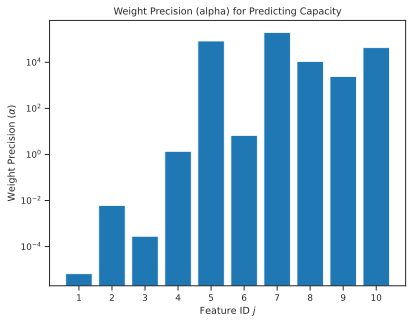

In [46]:
# Extract the weight precisions (alpha) for the power now
alpha = model_ard.lambda_
num_features = len(alpha)

formatted_alpha = [f'{a:.3f}' for a in alpha]
print(f'Weight Precisions: {formatted_alpha}')

# Plot the weight precisions (alpha) for each feature
plt.figure()
plt.bar(np.arange(num_features), alpha)
plt.xlabel('Feature ID $j$')
plt.ylabel(r'Weight Precision ($\alpha$)')
plt.yscale('log')  # Set y-axis to logarithmic scale

# Adjust x-axis ticks and labels
plt.xticks(np.arange(num_features), np.arange(num_features) + 1)
plt.title('Weight Precision (alpha) for Predicting Capacity')
plt.show()

Above plot has the weight precisions associated with the original polynomial model.We [recall](https://https://predictivesciencelab.github.io/data-analytics-se/lecture15/hands-on-15.2.html) that very high precision means that the corresponding basis function can be safely removed from your model. In this case we can remove all basis functions except first three. i.e. $$
w_1 , w_2T_e , w_3 T_c$$
Except these 3, all other alphas are several order magnitude higher.
So only important are first three indices. You could include 4th one with index 4 but consider its several order higher magnitude still and may lead to overfitting.

     Feature  Coefficient  Absolute Coefficient
0          1   381.556478            381.556478
2        T_c    59.562552             59.562552
1        T_e   -12.778398             12.778398
3      T_e^2    -0.854871              0.854871
5      T_c^2    -0.386315              0.386315
8  T_e T_c^2     0.020373              0.020373
4    T_e T_c     0.000000              0.000000
6      T_e^3     0.000000              0.000000
7  T_e^2 T_c     0.000000              0.000000
9      T_c^3     0.000000              0.000000


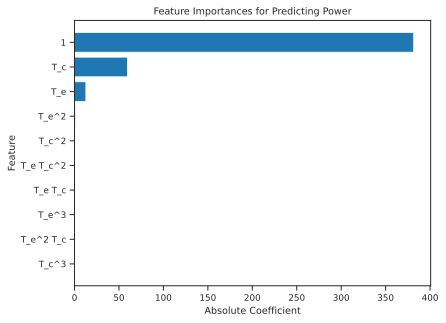

In [47]:
# Extract coefficients (importances) and their corresponding feature names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model_ard.coef_
})

# Sort by the absolute value of coefficients to identify the most important features
importance_df['Absolute Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# Print or display the most important features
print(importance_df)

# Plot the coefficients (importances)
plt.figure()
plt.barh(importance_df['Feature'], importance_df['Absolute Coefficient'])
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importances for Predicting Power')
plt.gca().invert_yaxis()
plt.show()

# Problem 3 - Explaining the Challenger disaster
On January 28, 1986, the [Space Shuttle Challenger](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) disintegrated after 73 seconds from launch.
The failure can be traced to the rubber O-rings, which were used to seal the joints of the solid rocket boosters (required to force the hot, high-pressure gases generated by the burning solid propellant through the nozzles, thus producing thrust).

The performance of the O-ring material was sensitive to the external temperature during launch.
This [dataset](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/challenger_data.csv) contains records of different experiments with O-rings recorded at various times between 1981 and 1986.
Download the data the usual way (either put them on Google Drive or run the code cell below).

In [48]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/challenger_data.csv"
download(url)

Even though this is a CSV file, you should load it with pandas because it contains some special characters.

In [49]:
raw_data = pd.read_csv('challenger_data.csv')
raw_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


The first column is the date of the record. The second column is the external temperature of that day in degrees F.
The third column labeled ``Damage Incident`` has a binary coding (0=no damage, 1=damage).
The very last row is the day of the Challenger accident.

We will use the first 23 rows to solve a binary classification problem that will give us the probability of an accident conditioned on the observed external temperature in degrees F. Before proceeding to the data analysis, let's clean the data up.

First, we drop all the bad records:

In [50]:
clean_data_0 = raw_data.dropna()
clean_data_0

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


We also don't need the last record. Remember that the temperature on the day of the Challenger accident was 31 degrees F.

In [51]:
clean_data = clean_data_0[:-1]
clean_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


Let's extract the features and the labels:

In [52]:
x = clean_data['Temperature'].values
x

array([66, 70, 69, 68, 67, 72, 73, 70, 57, 63, 70, 78, 67, 53, 67, 75, 70,
       81, 76, 79, 75, 76, 58])

In [53]:
y = clean_data['Damage Incident'].values.astype(np.float64)
y

array([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1.])

## Part A - Perform logistic regression

Perform logistic regression between the temperature ($x$) and the damage label ($y$).
Refrain from validating because there is little data.
Just use a simple model so that you don't overfit.

In [54]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Design matrix
poly = PolynomialFeatures(1)
Phi = poly.fit_transform(x[:, None])

# Fit
model_lr = LogisticRegression(
    penalty=None,
    fit_intercept=False
).fit(Phi, y)

## Part B - Plot the probability of damage as a function of temperature
Plot the probability of damage as a function of temperature.

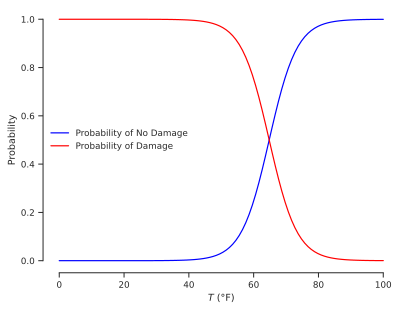

In [55]:
# your code here
fig, ax = plt.subplots()
test_sample_data = np.linspace(0, 100, 100)
Phi_test = poly.fit_transform(test_sample_data[:, None])
predictions_temp = model_lr.predict_proba(Phi_test)
ax.plot(
    test_sample_data,
    predictions_temp[:, 0],
    label='Probability of No Damage', color ='b'
)
ax.plot(
    test_sample_data,
    predictions_temp[:, 1],
    label='Probability of Damage', color = 'r'
)
ax.set_xlabel("$T$ ($\degree$F)")
ax.set_ylabel('Probability')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Part C - Decide whether or not to launch

The temperature on the day of the Challenger accident was 31 degrees F.
Start by calculating the probability of damage at 31 degrees F.
Then, use formal decision-making (i.e., define a cost matrix and make decisions by minimizing the expected loss) to decide whether or not to launch on that day.
Also, plot your optimal decision as a function of the external temperature.

In [56]:
# Predict the probability of damage at 31 degrees Fahrenheit
temp_31F = np.array([[31]])
Phi_31F = poly.transform(temp_31F)
probability_damage_31F = model_lr.predict_proba(Phi_31F)[:, 1]

print(f"Probability of damage at 31 degrees Fahrenheit: {probability_damage_31F[0]:.4f}")

Probability of damage at 31 degrees Fahrenheit: 0.9996


In [57]:
# Define cost matrices

# c_00 = cost of correctly picking 0 when 0 is true
# c_01 = cost of wrongly picking 0 when 1 is true
# c_11 = cost of correctly picking 1 when 1 is true
# c_10 = cost of wrongly picking 1 when 0 is true

cost_matrix = np.array(
    [
        [0.0, 1.0],
        [1.0, 0.0]
    ]
)

def expected_cost(cost_matrix, prediction_prob):
    """Calculate the expected cost of each decision.

    Arguments
    cost_matrix     --  A D x D matrix. `cost_matrix[i, j]`
                        is the cost of picking `i` and then
                        `j` happens.
    prediction_prob --  An array with D elements containing
                        the probability that each event
                        happens.
    """
    assert cost_matrix.ndim == 2
    D = cost_matrix.shape[0]
    assert cost_matrix.shape[1] == D
    assert prediction_prob.ndim == 1
    assert prediction_prob.shape[0] == D
    res = np.zeros((2,))
    for i in range(D):
        res[i] = np.dot(cost_matrix[i, :], prediction_prob)
    return res


# print('Temperatures\tCost of 0\tCost of 1\tTrue label\tChoice')
print('Temperatures\tCost of 0\tCost of 1\tChoice')
print('-' * 80)

for i in range(test_sample_data.shape[0]):
    exp_c = expected_cost(cost_matrix, predictions_temp[i])
    line = f'{test_sample_data[i]:1.1f}\t\t{exp_c[0]:1.4f}'
    tmp = f'\t\t{exp_c[1]:1.4f}'
    launch_decision = None

    if exp_c[0] < exp_c[1]:
        line += '*'
        launch_decision = "\t\tNo Damage - Launch"
    else:
        tmp += '*'
        launch_decision = "\t\tDamage - No Launch"
    line += tmp
    line += launch_decision
    print(line)

Temperatures	Cost of 0	Cost of 1	Choice
--------------------------------------------------------------------------------
0.0		1.0000		0.0000*		Damage - No Launch
1.0		1.0000		0.0000*		Damage - No Launch
2.0		1.0000		0.0000*		Damage - No Launch
3.0		1.0000		0.0000*		Damage - No Launch
4.0		1.0000		0.0000*		Damage - No Launch
5.1		1.0000		0.0000*		Damage - No Launch
6.1		1.0000		0.0000*		Damage - No Launch
7.1		1.0000		0.0000*		Damage - No Launch
8.1		1.0000		0.0000*		Damage - No Launch
9.1		1.0000		0.0000*		Damage - No Launch
10.1		1.0000		0.0000*		Damage - No Launch
11.1		1.0000		0.0000*		Damage - No Launch
12.1		1.0000		0.0000*		Damage - No Launch
13.1		1.0000		0.0000*		Damage - No Launch
14.1		1.0000		0.0000*		Damage - No Launch
15.2		1.0000		0.0000*		Damage - No Launch
16.2		1.0000		0.0000*		Damage - No Launch
17.2		1.0000		0.0000*		Damage - No Launch
18.2		1.0000		0.0000*		Damage - No Launch
19.2		1.0000		0.0000*		Damage - No Launch
20.2		1.0000		0.0000*		Damage - No Launch
21.2		1

For example we just saw that there is high probability of damage at 31F as calculated and also shown in this trend. Also its better to have cost matrix incorrectly points toward Damage incident rather than No Damage indicent than the other way. Choice of No Damage at 31F is 0.9995 while the expected loss of choosing Damage incident is 0.0004. To minimize the expected loss, we can assume that damage will occur and wisely NOT choose to proceed with the launch.

Similarly for other temperature / days, according to the trend based on the cost we can make a decision of launch vs no launch based on damanage incidednt choices predicted from temperature values on  different days. Note we here have put same penalty for both classes in the cost functions calculation. We could modify the cost matrix to put imbalanced cost for different scenarios. Below isn an example.


```
cost_matrix = np.array(
    [
        [0.0, 10.0],
        [1.0, 0.0]
    ]
)
```



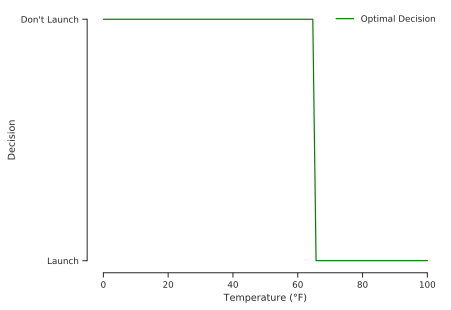

In [58]:
#  Plot optimal decision as a function of the external temperature

# Empty list of decisions
optimal_choices = []
for i in range(test_sample_data.shape[0]):
    exp_c = expected_cost(cost_matrix, predictions_temp[i])
    optimal_choice = np.argmin(exp_c)
    optimal_choices.append(optimal_choice)

# Plot optimal decisions
fig, ax = plt.subplots()
ax.plot(test_sample_data, optimal_choices, label='Optimal Decision', color = 'g')
ax.set_yticks([0, 1])
ax.set_yticklabels(["Launch", "Don't Launch"])
ax.set_ylabel("Decision")
ax.set_xlabel("Temperature ($\degree$F)")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True)
plt.show()

**End of Homework4**


In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
!sudo apt-get install inkscape texlive-xetex

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
inkscape is already the newest version (1.1.2-3ubuntu1).
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [65]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/Colab Notebooks/Shaunak_Mukherjee_ME539_homework-04_final.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Shaunak_Mukherjee_ME539_homework-04_final.ipynb to pdf
Failed to get connection
** (inkscape:9625): CRITICAL **: 01:38:14.680: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (inkscape:9625): CRITICAL **: 01:38:14.680: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (inkscape:9625): CRITICAL **: 01:38:14.680: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (inkscape:9633): CRITICAL **: 01:38:15.552: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (inkscape:9633): CRITICAL **: 01:38:15.552: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (inkscape:9633): CRITICAL **: 01:38:15.552: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (inkscape:9637): CRITICAL **: 01:38:15.954: dbus_g_proxy_new_for_name: assertion 'connection != NULL' f